# Recurrent Neural Network
This file traines a recurrent neural network on the melspectogram features

In [1]:
import json
import yaml
from pathlib import Path
from lib_util import utils, plot


import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping 
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy

from keras.layers import (
    Input,
    GlobalAvgPool1D,
    Dense,
    Bidirectional,
    GRU,
    Dropout,
)
from keras.models import Model, load_model
from keras.optimizers import Adam

from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import clip_ops

%load_ext autoreload
%autoreload 2
%matplotlib inline

2023-01-15 16:54:28.601885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Define crossentropy and accuracy metric for the training routine

For the metric we use a binary accuracy, for the loss a binary cross-entropy loss

In [2]:
def custom_binary_accuracy(y_true, y_pred, threshold=0.5):
    """Calculating the accuracy for the model where the treshold is 0.5 and the result will be between 0 and 1 
    """
    threshold = math_ops.cast(threshold, y_pred.dtype)
    y_pred = math_ops.cast(y_pred > threshold, y_pred.dtype)
    y_true = math_ops.cast(y_true > threshold, y_true.dtype)

    return K.mean(math_ops.equal(y_true, y_pred), axis=-1)


def custom_binary_crossentropy(y_true, y_pred):
    """Calculating the cross entropy from probabilities where the result will be between 0 and 1
    """
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    epsilon_ = K._constant_to_tensor(K.epsilon(), y_pred.dtype.base_dtype)
    output = clip_ops.clip_by_value(y_pred, epsilon_, 1.0 - epsilon_)

    # Compute cross entropy from probabilities.
    bce = 4 * y_true * math_ops.log(output + K.epsilon())
    bce += (1 - y_true) * math_ops.log(1 - output + K.epsilon())
    return K.sum(-bce, axis=-1)

# Define the model

define the RNN model structure 

In [3]:
def rnn_model(model_config, n_classes):
    """RNN model where the model will be trained on the training data
    """
    d_model = model_config['d_model']
    n_layers = model_config['n_layers']
    init_lr = model_config['init_learning_rate']
    dropout_rate = model_config['dropout_rate']
    activations = model_config['activations']
    inp = Input((None, d_model))
    #Bidirectional means having a neural network in both directions backwards
    x = Bidirectional(GRU(d_model, return_sequences=True))(inp)
    # Making different bidirectional layers 
    if n_classes > 1:
        for i in range(n_layers):
            x = Bidirectional(GRU(d_model, return_sequences=True))(x)

    x = Dropout(dropout_rate)(x)
    x = GlobalAvgPool1D()(x)
    x = Dense(4 * n_classes, activation=activations[0])(x)
    out = Dense(n_classes, activation=activations[1])(x)
    model = Model(inputs=inp, outputs=out)

    loss = BinaryCrossentropy(
        name='binary_crossentropy'
    )
    
    metric = BinaryAccuracy(
        name='binary_accuracy'
    )
    
    model.compile(
        optimizer=Adam(init_lr), loss=loss, metrics=metric
    )

    model.summary()

    return model

# Main routine

Load the configuration for this model

In [4]:
config = utils.get_config('rnn')

# Extract the values
model_name = config['model_name']
batch_size = config['batch_size']
epochs = config['epochs']

# Load preprocessed data

Load the numpy arrays and the label-class mapping. Split the data accordingly into train, validation and test set

In [5]:
melspec_data = utils.load_sliced_numpy_array('melspec_features')
labels = np.load('data/labels.npy')

labels_to_id = utils.get_class_mapping()

mel_train, mel_test_val, lab_train, lab_test_val = train_test_split(melspec_data, labels, train_size=config['train_set_size'], random_state=config['random_state'])
mel_val, mel_test, lab_val, lab_test             = train_test_split(mel_test_val, lab_test_val, test_size=(config['val_set_size']/(1-config['train_set_size'])), shuffle=False)

# Check the shapes of the splitted sets
assert mel_train.shape[0] == lab_train.shape[0] and mel_test.shape[0] == lab_test.shape[0] and mel_val.shape[0] == lab_val.shape[0]
assert mel_train.shape[1] == mel_test.shape[1] == mel_val.shape[1] and lab_train.shape[1] == lab_test.shape[1] == lab_val.shape[1]

Load slice from file melspec_features_001.npy
Load slice from file melspec_features_002.npy
Load slice from file melspec_features_003.npy
Load slice from file melspec_features_004.npy
Load slice from file melspec_features_005.npy
Load slice from file melspec_features_006.npy
Load slice from file melspec_features_007.npy
Load slice from file melspec_features_008.npy
Load slice from file melspec_features_009.npy
Load slice from file melspec_features_010.npy
Load slice from file melspec_features_011.npy
Load slice from file melspec_features_012.npy
Loaded 12 files as slices, resulting shape: (4068, 33152)


# Set up the model callbacks

For initializing parameters, refer to the config file. For callbacks, we use a frequently backup of the model as checkpoints, and early stopping mechanism to prevent overfitting on the train data and a learning rate reducer. The learning rate reducer smallers the update step when the validation metric does not improve anymore

In [6]:
train_config = config['training']

checkpoint = ModelCheckpoint(
    f'models/{model_name}',
    monitor=train_config['monitor'],
    verbose=1,
    save_best_only=train_config['save_best_weights'],
    mode=train_config['monitor_mode'],
    save_weights_only=False
)


es_config = config['training']['early_stopping']
early_stopping = EarlyStopping(
    monitor = es_config['monitor'],
    patience = es_config['patience'],
    verbose = 1,
    mode = es_config['mode'],
    restore_best_weights = True,
    start_from_epoch = es_config['start_from_epoch']
)

# Reduce learning rate when val_loss stopps improving
lr_reduce_config = train_config['lr_reducing']
lr_reducing_on_platteau = ReduceLROnPlateau(
    monitor=lr_reduce_config['monitor'], patience=lr_reduce_config['patience'], min_lr=lr_reduce_config['min_lr'], mode=lr_reduce_config['mode']
    )

# Train routine

In [7]:
# read in the config
pp_config = utils.get_config('preprocess')

n_mels = pp_config['melspectogram']['n_mels']
mel_train = mel_train.reshape(mel_train.shape[0], -1, n_mels)
mel_val   = mel_val.reshape(mel_val.shape[0], -1, n_mels)

model = rnn_model(config['model_structure'], n_classes=len(labels_to_id))

history = model.fit(
        x=mel_train,
        y=lab_train,
        validation_data=(mel_val, lab_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[checkpoint, lr_reducing_on_platteau, early_stopping],
        use_multiprocessing=True,
        verbose=2
    )


2023-01-15 16:54:44.157880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 128)]       0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        198144    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 256)        296448    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 256)        296448    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                             

INFO:tensorflow:Assets written to: models/rnn/assets


INFO:tensorflow:Assets written to: models/rnn/assets


20/20 - 123s - loss: 0.5065 - binary_accuracy: 0.7896 - val_loss: 0.4880 - val_binary_accuracy: 0.7998 - lr: 1.0000e-04 - 123s/epoch - 6s/step
Epoch 2/40

Epoch 2: val_loss improved from 0.48798 to 0.46758, saving model to models/rnn


INFO:tensorflow:Assets written to: models/rnn/assets


INFO:tensorflow:Assets written to: models/rnn/assets


20/20 - 106s - loss: 0.4749 - binary_accuracy: 0.7999 - val_loss: 0.4676 - val_binary_accuracy: 0.7998 - lr: 1.0000e-04 - 106s/epoch - 5s/step
Epoch 3/40

Epoch 3: val_loss improved from 0.46758 to 0.45577, saving model to models/rnn


INFO:tensorflow:Assets written to: models/rnn/assets


INFO:tensorflow:Assets written to: models/rnn/assets


20/20 - 88s - loss: 0.4563 - binary_accuracy: 0.8032 - val_loss: 0.4558 - val_binary_accuracy: 0.8010 - lr: 1.0000e-04 - 88s/epoch - 4s/step
Epoch 4/40

Epoch 4: val_loss improved from 0.45577 to 0.43748, saving model to models/rnn


INFO:tensorflow:Assets written to: models/rnn/assets


INFO:tensorflow:Assets written to: models/rnn/assets


20/20 - 92s - loss: 0.4367 - binary_accuracy: 0.8111 - val_loss: 0.4375 - val_binary_accuracy: 0.8101 - lr: 1.0000e-04 - 92s/epoch - 5s/step
Epoch 5/40

Epoch 5: val_loss improved from 0.43748 to 0.42484, saving model to models/rnn


INFO:tensorflow:Assets written to: models/rnn/assets


INFO:tensorflow:Assets written to: models/rnn/assets


20/20 - 93s - loss: 0.4183 - binary_accuracy: 0.8223 - val_loss: 0.4248 - val_binary_accuracy: 0.8147 - lr: 1.0000e-04 - 93s/epoch - 5s/step
Epoch 6/40

Epoch 6: val_loss improved from 0.42484 to 0.40943, saving model to models/rnn


INFO:tensorflow:Assets written to: models/rnn/assets


INFO:tensorflow:Assets written to: models/rnn/assets


20/20 - 104s - loss: 0.3971 - binary_accuracy: 0.8296 - val_loss: 0.4094 - val_binary_accuracy: 0.8273 - lr: 1.0000e-04 - 104s/epoch - 5s/step
Epoch 7/40

Epoch 7: val_loss improved from 0.40943 to 0.40093, saving model to models/rnn


INFO:tensorflow:Assets written to: models/rnn/assets


INFO:tensorflow:Assets written to: models/rnn/assets


20/20 - 89s - loss: 0.3791 - binary_accuracy: 0.8356 - val_loss: 0.4009 - val_binary_accuracy: 0.8260 - lr: 1.0000e-04 - 89s/epoch - 4s/step
Epoch 8/40

Epoch 8: val_loss improved from 0.40093 to 0.38720, saving model to models/rnn


INFO:tensorflow:Assets written to: models/rnn/assets


INFO:tensorflow:Assets written to: models/rnn/assets


20/20 - 81s - loss: 0.3657 - binary_accuracy: 0.8425 - val_loss: 0.3872 - val_binary_accuracy: 0.8312 - lr: 1.0000e-04 - 81s/epoch - 4s/step
Epoch 9/40

Epoch 9: val_loss improved from 0.38720 to 0.37768, saving model to models/rnn


INFO:tensorflow:Assets written to: models/rnn/assets


INFO:tensorflow:Assets written to: models/rnn/assets


20/20 - 91s - loss: 0.3516 - binary_accuracy: 0.8513 - val_loss: 0.3777 - val_binary_accuracy: 0.8388 - lr: 1.0000e-04 - 91s/epoch - 5s/step
Epoch 10/40


In [ ]:
to_dump = {
    'model': model,
    'history': history,
    'config': config
}

utils.save_training(to_dump, model_name)

INFO:tensorflow:Assets written to: models/rnn_trained/assets


INFO:tensorflow:Assets written to: models/rnn_trained/assets


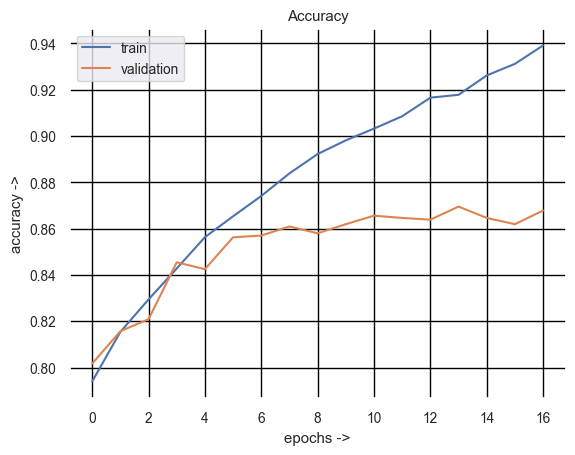

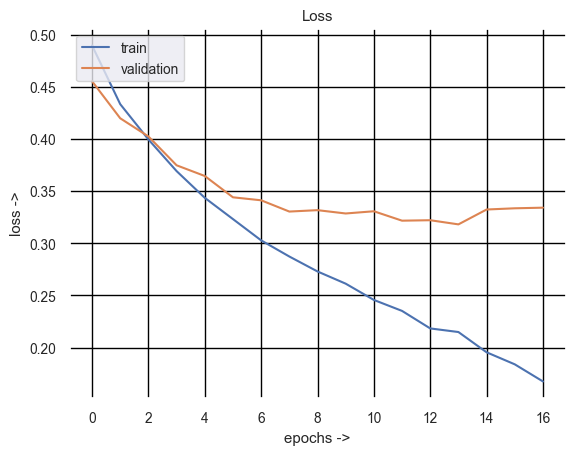

In [ ]:
history = utils.load_history(model_name)

#Plots for the accuracies and losses of the train and validation data per epoch
plot.plot_hist(history, ('binary_accuracy', 'val_binary_accuracy'), legends=('train', 'validation'), title='Accuracy', y_label='accuracy ->', x_label='epochs ->', save_to=f'Plots/short_chunk_cnn_{epochs}_acuracy')
plot.plot_hist(history, ('loss', 'val_loss'), legends=('train', 'validation'), title='Loss', y_label='loss ->', x_label='epochs ->', save_to=f'Plots/short_chunk_cnn_{epochs}_loss')

In [ ]:
predict = lambda model, data: np.argmax(model.predict(data), axis=-1)

mel_test = mel_test.reshape(mel_test.shape[0], -1, n_mels)

#Loading in the model
model = utils.load_model(model_name)

# Training prediction
y_pred_train = predict(model, mel_train)
y_true_train = np.argmax(lab_train, axis= -1)
print(f"ACCURACY FOR TRAIN SET {accuracy_score(y_true_train, y_pred_train)*100:.4f} %")
print(f"MACRO F1 SCORE FOR TRAIN SET {f1_score(y_true_train, y_pred_train, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR TRAIN SET {f1_score(y_true_train, y_pred_train, average='micro')*100:.4f} %")
print(f"WEIGHTED F1 SCORE FOR TRAIN SET {f1_score(y_true_train, y_pred_train, average='weighted')*100:.4f} %")


# Validation prediction
y_pred_val = predict(model, mel_val)
y_true_val = np.argmax(lab_val, axis= -1)
print(f"ACCURACY FOR VAL SET {accuracy_score(y_true_val, y_pred_val)*100:.4f} %")
print(f"MACRO F1 SCORE FOR VAL SET {f1_score(y_true_val, y_pred_val, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR VAL SET {f1_score(y_true_val, y_pred_val, average='micro')*100:.4f} %")
print(f"WEIGHTED F1 SCORE FOR TRAIN SET {f1_score(y_true_val, y_pred_val, average='weighted')*100:.4f} %")


# Test prediction
y_pred_test = predict(model, mel_test)
y_true_test = np.argmax(lab_test, axis= -1)
print(f"ACCURACY FOR TEST SET {accuracy_score(y_true_test, y_pred_test)*100:.4f} %")
print(f"MACRO F1 SCORE FOR TEST SET {f1_score(y_true_test, y_pred_test, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR TEST SET {f1_score(y_true_test, y_pred_test, average='micro')*100:.4f} %")
print(f"WEIGHTED F1 SCORE FOR TEST SET {f1_score(y_true_test, y_pred_test, average='weighted')*100:.4f} %")

77/77 [==============================] - 12s 136ms/step
ACCURACY FOR TRAIN SET 85.2049 %
MACRO F1 SCORE FOR TRAIN SET 83.4957 %
MICRO F1 SCORE FOR TRAIN SET 85.2049 %
WEIGHTED F1 SCORE FOR TRAIN SET 85.0153 %
26/26 [==============================] - 4s 136ms/step
ACCURACY FOR VAL SET 65.2334 %
MACRO F1 SCORE FOR VAL SET 63.3359 %
MICRO F1 SCORE FOR VAL SET 65.2334 %
WEIGHTED F1 SCORE FOR TRAIN SET 65.0840 %
26/26 [==============================] - 4s 132ms/step
ACCURACY FOR TEST SET 69.0418 %
MACRO F1 SCORE FOR TEST SET 67.5713 %
MICRO F1 SCORE FOR TEST SET 69.0418 %
WEIGHTED F1 SCORE FOR TEST SET 68.6406 %


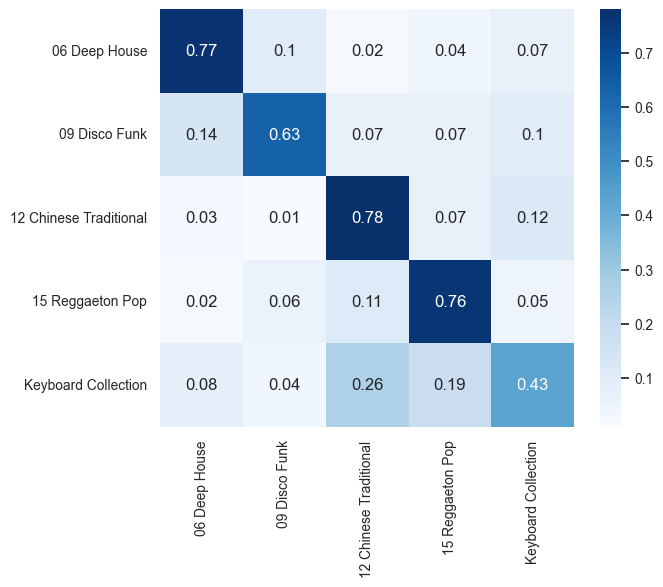

In [ ]:
class_names = utils.get_class_names()

#Confusion matrix of the predicted labels versus the true labels
conf_mat = confusion_matrix(y_true_test, y_pred_test, normalize= 'true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = pd.DataFrame(conf_mat, columns=class_names, index=class_names)

plot.plot_conf_mat(conf_mat_df, save_to=f"Plots/{model_name}{epochs}_test_conf_mat.png")